## Importing Dependencies and loading Data

In [114]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

cundle_symbol = 'DX-Y.NYB'
cundle = yf.Ticker(cundle_symbol)
df = cundle.history(period='5y').reset_index(drop=False)
df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

In [115]:
df

,Date,Open,High,Low,Close
0,2019-11-06 00:00:00-05:00,97.940002,97.980003,97.779999,97.949997
1,2019-11-07 00:00:00-05:00,97.949997,98.230003,97.820000,98.139999
2,2019-11-08 00:00:00-05:00,98.139999,98.400002,98.099998,98.349998
3,2019-11-11 00:00:00-05:00,98.370003,98.379997,98.129997,98.199997
4,2019-11-12 00:00:00-05:00,98.209999,98.419998,98.209999,98.309998
...,...,...,...,...,...
1254,2024-10-31 00:00:00-04:00,104.089996,104.220001,103.820000,103.980003
1255,2024-11-01 00:00:00-04:00,103.860001,104.349998,103.680000,104.279999
1256,2024-11-04 00:00:00-05:00,103.970001,103.970001,103.580002,103.889999
1257,2024-11-05 00:00:00-05:00,103.910004,103.959999,103.370003,103.419998


In [116]:
fig = px.line(df, x='Date', y=['Open', 'High', 'Low', 'Close'], title='US Dollar Index', height=1000)
fig.show()

Time series are not static, meaning their statistical properties change over time.

---
We observe that in October 2024, the price forms a bullish (upward) trend, with the value of the dollar increasing. This trend may be driven by the elections in the United States and the economic and political changes proposed, which significantly impact the economy.

---
It is not possible to predict the dollar's value for the next day if we only have information about today, as we cannot perform any statistical analysis to identify a trend in the price.

---
In this case, we are attempting to analyze the trend of the dollar as a function of time in order to make a future prediction. To do this, we obviously need the temporal information within the data. By shuffling the data randomly, we destroy the time-related information, and consequently, we cannot perform any meaningful analysis.

In [117]:
df

,Date,Open,High,Low,Close
0,2019-11-06 00:00:00-05:00,97.940002,97.980003,97.779999,97.949997
1,2019-11-07 00:00:00-05:00,97.949997,98.230003,97.820000,98.139999
2,2019-11-08 00:00:00-05:00,98.139999,98.400002,98.099998,98.349998
3,2019-11-11 00:00:00-05:00,98.370003,98.379997,98.129997,98.199997
4,2019-11-12 00:00:00-05:00,98.209999,98.419998,98.209999,98.309998
...,...,...,...,...,...
1254,2024-10-31 00:00:00-04:00,104.089996,104.220001,103.820000,103.980003
1255,2024-11-01 00:00:00-04:00,103.860001,104.349998,103.680000,104.279999
1256,2024-11-04 00:00:00-05:00,103.970001,103.970001,103.580002,103.889999
1257,2024-11-05 00:00:00-05:00,103.910004,103.959999,103.370003,103.419998


In [118]:
train = df[df['Date'] < '2024'].drop(columns='Date')
test = df[df['Date'] >= '2024'].drop(columns='Date')

df.shape, train.shape, test.shape

((1259, 5), (1044, 4), (215, 4))

In [119]:
def get_windows(df, N):
  inputs = []
  targets = []

  for i in range(len(df)-N):
    inputs.append(df.iloc[i:i+N].values)
    targets.append(df['Close'].iloc[i+N])

  inputs = np.array(inputs)
  targets = np.array(targets)
  return inputs, targets

If our goal is to predict the next day's value, the timeframe should span a few days to allow us to observe the local or short-term trend of the dollar. Conversely, if we aim to invest with a more long-term objective, such as after a month, we need to expand the timeframe to analyze the trend on a monthly scale, for example, using N=60-100 days.

In [120]:
x_train, y_train = get_windows(train, 5)
x_test, y_test = get_windows(test, 5)

print('Before reshape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train = np.reshape(x_train, [len(x_train), -1])
x_test = np.reshape(x_test, [len(x_test), -1])

print('After reshape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Before reshape: (1039, 5, 4) (1039,) (210, 5, 4) (210,)
After reshape: (1039, 20) (1039,) (210, 20) (210,)


### Linear Regression
---

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
total_mae = []

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

lr_mae = mean_absolute_error(lr_model.predict(x_test), y_test)
total_mae.append(lr_mae)
print('MAE in training set:', mean_absolute_error(lr_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(lr_model.predict(x_test), y_test))

MAE in training set: 0.3392997191888845
MAE in test set:  0.27191512839614107


### Random Forest Regressor
---

In [122]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=6) # Max depth -> prevent overfitting
rf_model.fit(x_train, y_train)

rf_mae = mean_absolute_error(rf_model.predict(x_test), y_test)
total_mae.append(rf_mae)
print('MAE in training set:', mean_absolute_error(rf_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(rf_model.predict(x_test), y_test))

MAE in training set: 0.2694118928903921
MAE in test set:  0.286333465109452


### Linear Regression with Bagging
---

In [123]:
from sklearn.ensemble import BaggingRegressor

br_model = BaggingRegressor(LinearRegression())
br_model.fit(x_train, y_train)

br_mae = mean_absolute_error(br_model.predict(x_test), y_test)
total_mae.append(br_mae)
print('MAE in training set:', mean_absolute_error(br_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(br_model.predict(x_test), y_test))

MAE in training set: 0.34031351530225973
MAE in test set:  0.2734508344445453


### XGBoost
---

In [124]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(alpha=6) # alpha -> L1 regularization parameter. Prevent overfitting
xgb_model.fit(x_train, y_train)

xgb_mae = mean_absolute_error(xgb_model.predict(x_test), y_test)
total_mae.append(xgb_mae)
print('MAE in training set:', mean_absolute_error(xgb_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(xgb_model.predict(x_test), y_test))

MAE in training set: 0.27745283051565134
MAE in test set:  0.3092815217517671


### Linear Regression with Stacking
---

In [125]:
from sklearn.ensemble import StackingRegressor

base_models = [
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('br', br_model)
]

sr_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
sr_model.fit(x_train, y_train)

sr_mae = mean_absolute_error(sr_model.predict(x_test), y_test)
total_mae.append(sr_mae)
print('MAE in training set:', mean_absolute_error(sr_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(sr_model.predict(x_test), y_test))

MAE in training set: 0.3380032264420183
MAE in test set:  0.2708963012034194


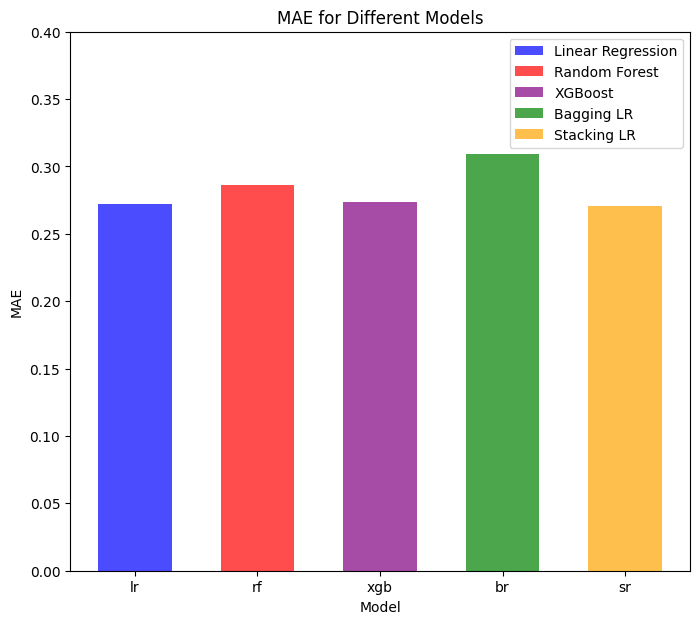

In [126]:
plt.figure(figsize=(8, 7))
plt.bar(['lr', 'rf', 'xgb', 'br', 'sr'], total_mae, width=0.6,label=['Linear Regression','Random Forest', 'XGBoost', 'Bagging LR', 'Stacking LR'] ,color=['blue', 'red', 'purple', 'green', 'orange'], alpha=0.7)
plt.title('MAE for Different Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.ylim(0, 0.4)
plt.legend()
plt.show()

**Linear Regression**: The model uses a linear function and fits it to the data of previous days to predict the next value.

**Random Forest Regression**: The model consists of multiple decision trees, which are trained on different "samples" of the original data using random sampling with replacement (bootstrap sampling) to perform regression. The final decision is made by averaging the predictions from all the individual trees.

**XGBoost Regression**: XGBoost uses decision trees optimized through the Extreme Gradient Boosting method. It also incorporates regularization and handles missing values, among other features. It is a highly optimized gradient boosting framework.

**Bagging Regression**: Bagging is a method for improving the performance of a model. It can use various models as estimators and enhances results by creating multiple instances of the models, which are trained on different samples of the original data using bootstrap sampling.

**Stacking Regression**: Stacking is a method where a model (meta-learner) is trained on the predictions of other models (base models).

In [127]:
train = df[df['Date'] < '2024'].copy()
test = df[df['Date'] >= '2024'].copy()

train.loc[:, 'Month'] = (train['Date'].dt.month - 1)/11
test.loc[:, 'Month'] = (test['Date'].dt.month - 1)/11

train.drop(columns='Date', inplace=True)
test.drop(columns='Date', inplace=True)

In [128]:
test

,Open,High,Low,Close,Month
1044,101.419998,102.250000,101.339996,102.199997,0.000000
1045,102.150002,102.730003,102.080002,102.459999,0.000000
1046,102.459999,102.529999,102.150002,102.419998,0.000000
1047,102.400002,103.099998,101.910004,102.410004,0.000000
1048,102.440002,102.620003,102.080002,102.209999,0.000000
...,...,...,...,...,...
1254,104.089996,104.220001,103.820000,103.980003,0.818182
1255,103.860001,104.349998,103.680000,104.279999,0.909091
1256,103.970001,103.970001,103.580002,103.889999,0.909091
1257,103.910004,103.959999,103.370003,103.419998,0.909091


---
The month can influence the value of the dollar due to seasonal variations, which may affect labor demand. Additionally, the price can be impacted by holidays, during which transaction volumes tend to increase. These changes are periodic and, therefore, predictable. Incorporating such seasonal patterns into the model could potentially improve its performance and accuracy.

In [129]:
for feat in train.columns[:-1]:
  train[feat] = np.log(train[feat].shift(-1)/train[feat])
  test[feat] = np.log(test[feat].shift(-1)/test[feat])

train.dropna(inplace=True) # Getting rif of the last value because it becomes NaN after applying the operator.
test.dropna(inplace=True)

In [130]:
test

,Open,High,Low,Close,Month
1044,0.007172,0.004683,0.007276,0.002541,0.000000
1045,0.003030,-0.001949,0.000685,-0.000390,0.000000
1046,-0.000586,0.005544,-0.002352,-0.000098,0.000000
1047,0.000391,-0.004667,0.001667,-0.001955,0.000000
1048,-0.002150,0.000390,0.000294,0.003516,0.000000
...,...,...,...,...,...
1253,-0.001536,-0.002109,-0.001540,-0.000096,0.818182
1254,-0.002212,0.001247,-0.001349,0.002881,0.818182
1255,0.001059,-0.003648,-0.000965,-0.003747,0.909091
1256,-0.000577,-0.000096,-0.002029,-0.004534,0.909091


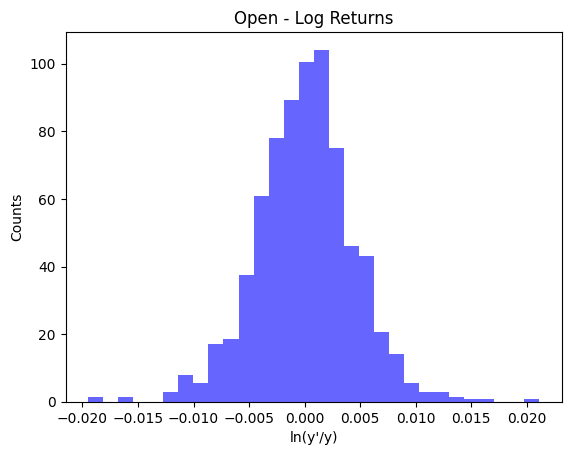

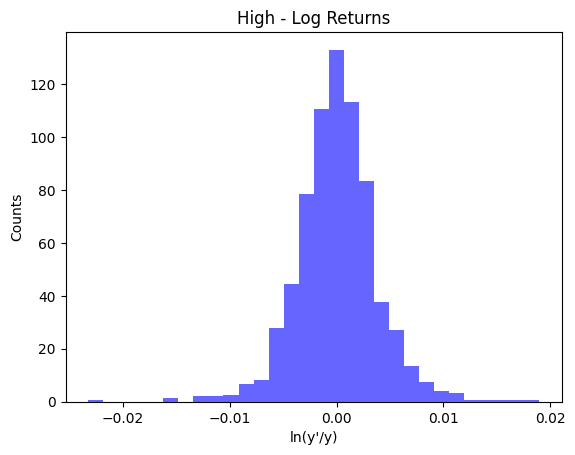

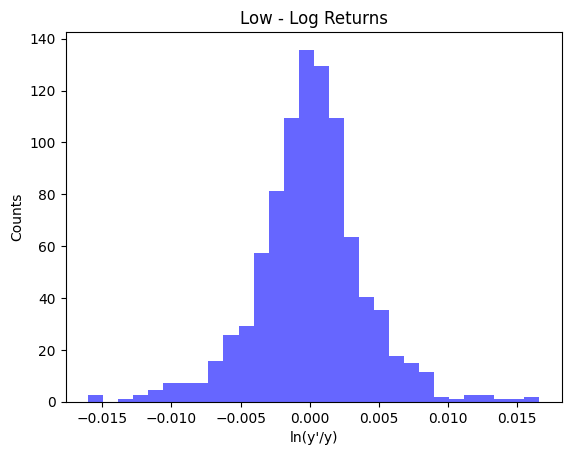

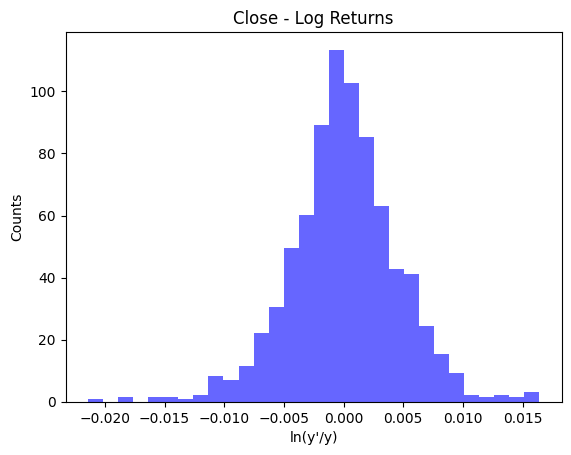

In [131]:
for feat in train.columns[:-1]:
  plt.hist(train[feat],bins=30 , color='blue', alpha=0.6, density=True)
  plt.title(f'{feat} - Log Returns')
  plt.ylabel('Counts')
  plt.xlabel("ln(y'/y)")
  plt.show()
  print('\n')

This transformation can improve predictions as it converts the data into statistical distributions with similar mean and standard deviation.

---

If the model predicts C = 0.01 it means the value will increase, since ln(x) > 0 when x > 1. To calculate the new value, we need to apply the inverse transformation.

If C = 0.95 ----> C_new = 0.95 * exp(0.01) ----> C_new =0.9595476587

---


In [132]:
x_train, y_train = get_windows(train, 5)
x_test, y_test = get_windows(test, 5)

print('Before reshape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train = np.reshape(x_train, [len(x_train), -1])
x_test = np.reshape(x_test, [len(x_test), -1])

print('After reshape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Before reshape: (1038, 5, 5) (1038,) (209, 5, 5) (209,)
After reshape: (1038, 25) (1038,) (209, 25) (209,)


### Linear Regression
---

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
total_mae = []

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

lr_mae = mean_absolute_error(lr_model.predict(x_test), y_test)
total_mae.append(lr_mae)
print('MAE in training set:', mean_absolute_error(lr_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(lr_model.predict(x_test), y_test))

MAE in training set: 0.003360486567515332
MAE in test set:  0.002717426719680505


### Random Forest Regressor
---

In [134]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=10) # Max depth -> prevent overfitting
rf_model.fit(x_train, y_train)

rf_mae = mean_absolute_error(rf_model.predict(x_test), y_test)
total_mae.append(rf_mae)
print('MAE in training set:', mean_absolute_error(rf_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(rf_model.predict(x_test), y_test))

MAE in training set: 0.002809633060193995
MAE in test set:  0.0026399532751850145


### Linear Regression with Bagging
---

In [135]:
from sklearn.ensemble import BaggingRegressor

br_model = BaggingRegressor(LinearRegression())
br_model.fit(x_train, y_train)

br_mae = mean_absolute_error(br_model.predict(x_test), y_test)
total_mae.append(br_mae)
print('MAE in training set:', mean_absolute_error(br_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(br_model.predict(x_test), y_test))

MAE in training set: 0.003371470751627724
MAE in test set:  0.002711978666251384


### XGBoost
---

In [136]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(alpha=6) # alpha -> L1 regularization parameter. Prevent overfitting
xgb_model.fit(x_train, y_train)

xgb_mae = mean_absolute_error(xgb_model.predict(x_test), y_test)
total_mae.append(xgb_mae)
print('MAE in training set:', mean_absolute_error(xgb_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(xgb_model.predict(x_test), y_test))

MAE in training set: 0.0034077188983875433
MAE in test set:  0.0026039197042713276


### Linear Regression with Stacking
---

In [137]:
from sklearn.ensemble import StackingRegressor

base_models = [
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('br', br_model)
]

sr_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
sr_model.fit(x_train, y_train)

sr_mae = mean_absolute_error(sr_model.predict(x_test), y_test)
total_mae.append(sr_mae)
print('MAE in training set:', mean_absolute_error(sr_model.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(sr_model.predict(x_test), y_test))

MAE in training set: 0.003442782418293037
MAE in test set:  0.0026235180269594087


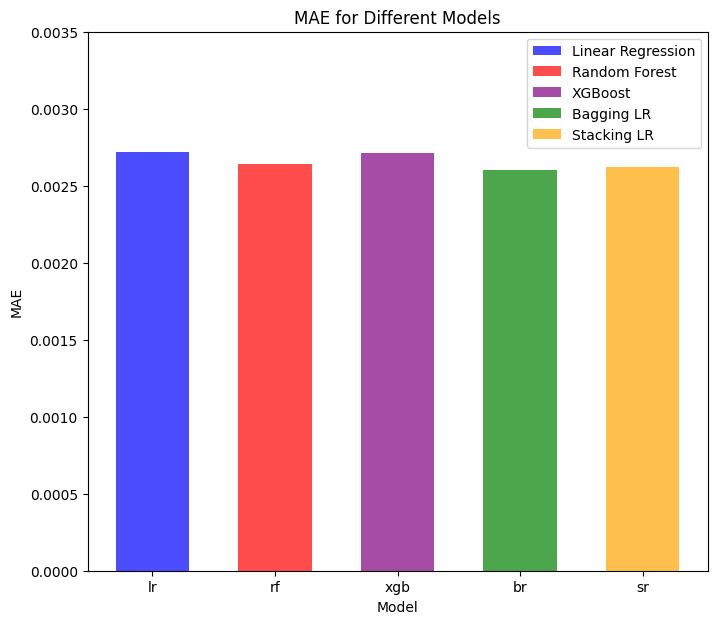

In [138]:
plt.figure(figsize=(8, 7))
plt.bar(['lr', 'rf', 'xgb', 'br', 'sr'], total_mae, width=0.6,label=['Linear Regression','Random Forest', 'XGBoost', 'Bagging LR', 'Stacking LR'] ,color=['blue', 'red', 'purple', 'green', 'orange'], alpha=0.7)
plt.title('MAE for Different Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.ylim(0, 0.0035)
plt.legend()
plt.show()

In [139]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.00000005) # alpha has to be extremely small otherwise the weights become zero?
lasso.fit(x_train, y_train)

print('MAE in training set:', mean_absolute_error(lasso.predict(x_train), y_train))
print('MAE in test set: ', mean_absolute_error(lasso.predict(x_test), y_test))

MAE in training set: 0.003361958032463165
MAE in test set:  0.0026954661093905644


In [140]:
print(abs(lasso.coef_))

[0.15286713 0.00723159 0.02084014 0.04344633 0.00243226 0.11129175
 0.11574276 0.         0.02443891 0.00503909 0.         0.08410428
 0.09623134 0.         0.00060755 0.01923681 0.12205522 0.08603221
 0.15039777 0.00269807 0.05004178 0.1784875  0.07827804 0.
 0.00154405]


In [141]:
# 10 most important features
coefficients = abs(lasso.coef_)
n_day = [i for i in range(1, 6) for k in range(5) ]
features = [feat for k in range(5) for feat in train.columns]

coef_df = pd.DataFrame({'n Day': n_day, 'Feature': features, 'Coefficients': coefficients})
print(coef_df.sort_values('Coefficients', ascending=False).head(10))

    n Day Feature  Coefficients
21      5    High      0.178488
0       1    Open      0.152867
18      4   Close      0.150398
16      4    High      0.122055
6       2    High      0.115743
5       2    Open      0.111292
12      3     Low      0.096231
17      4     Low      0.086032
11      3    High      0.084104
22      5     Low      0.078278


In [142]:
coef_df.head(7)

,n Day,Feature,Coefficients
0,1,Open,0.152867
1,1,High,0.007232
2,1,Low,0.020840
3,1,Close,0.043446
4,1,Month,0.002432
5,2,Open,0.111292
6,2,High,0.115743


We observe that the 'Month' does not appear among the top 10 most important features. Additionally, it seems that, theoretically, the 5th day (the day before t+1) carries the most weight. However, in the top 10 values, all days appear to be scattered, indicating that, in general, all days contribute equally to the prediction.

---

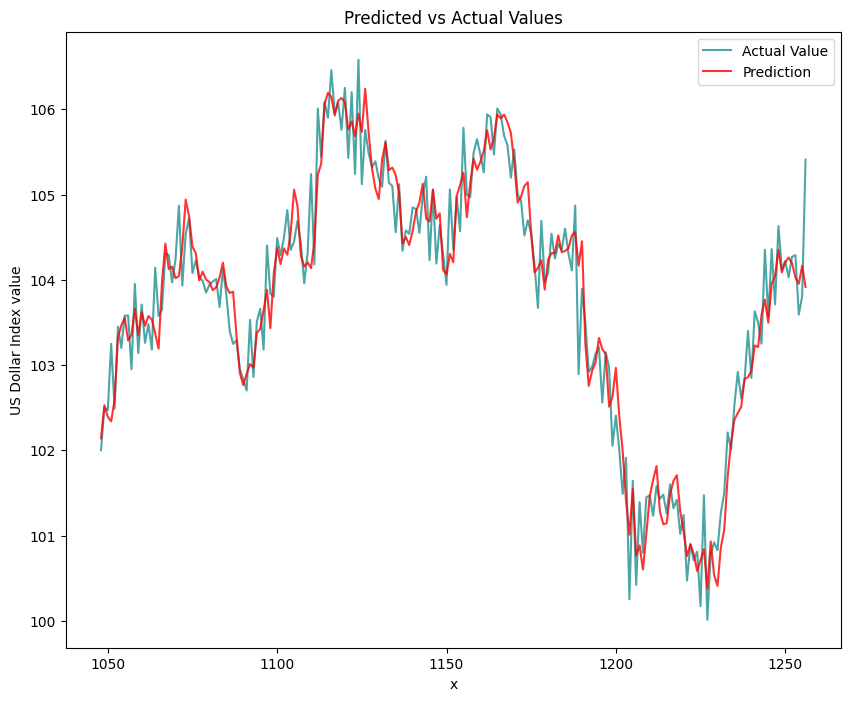

In [157]:
y_pred = lasso.predict(x_test)
C_previous = df[df['Date'] >= '2024']['Close'].copy().iloc[4:-2] # Previous Values: With N=5, the first prediction is in index 5, so the first 'previous' value is in index 4. Also we cut the last value to much the dimensions.

abs_pred = C_previous*np.exp(y_pred)
abs_test = C_previous*np.exp(y_test)

plt.figure(figsize=(10,8))
plt.plot(abs_test, color='teal', label='Actual Value', alpha=0.7)
plt.plot(abs_pred, color='red', label= 'Prediction', alpha=0.8)
plt.title('Predicted vs Actual Values')
plt.ylabel('US Dollar Index value')
plt.xlabel('x')
plt.legend()
plt.show()